# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import pathlib
import PIL
import os
import time
from glob import glob

from PIL import Image as PImage
from PIL import ImageFilter
import random
import math

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


AUTOTUNE = tf.data.AUTOTUNE


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Creating the data pipeline


Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

first parameters for loading

In [4]:
batch_size = 64 
img_height = 64
img_width = 64
epochs = 30

validation = 0.2

data_dir = 'Data/characters/'

In [5]:

#data_dir = pathlib.Path('Data/mnist/')
#data_dir = pathlib.Path('Data/characters/')
'''
low = list(data_dir.glob('低/*'))
for i in range(9):
    PIL.Image.open(str(low[i])) '''

"\nlow = list(data_dir.glob('低/*'))\nfor i in range(9):\n    PIL.Image.open(str(low[i])) "

Split the data into 80% training and 20% testing

In [6]:
from glob import glob
import random

def make_dataset(path, batch_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [img_height, img_width])
    return image

  def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    #ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  dataset_size = len(filenames)
  random.shuffle(filenames)
  labels = [classes.index(name.split(os.path.sep)[-2]) for name in filenames]

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds, classes, dataset_size

In [7]:
dataset, class_names, dataset_size = make_dataset(data_dir, batch_size)

val_size = int(validation * dataset_size / batch_size)

print(f'Size: {dataset_size}, val: {val_size * batch_size}')


val_ds = dataset.take(val_size)

train_ds = dataset.skip(val_size)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05,0.05), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.0, 0.5), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1), fill_mode='constant', fill_value=0)
])

#train_ds = train_ds.map()

# PRINT VALIDATION HERE

Size: 610236, val: 121984


# Train the model

## Set up model

structures from [2]

In [8]:
from models import *

model = get_LargeKernel(len(class_names))

#can't have here with the resize layer
#model.summary()

In [9]:
model_dir = 'D:\\MachineLearning\\models'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [10]:
sched = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 10 * (tf.data.experimental.cardinality(train_ds).numpy()) ,
    decay_rate = 0.9,
    staircase = True,
)


optimizer = tf.keras.optimizers.Adam(learning_rate=sched,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-8,)
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [13]:
model = tf.keras.models.load_model(os.path.join(model_dir, "tf", "trained_model"))
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-30-0.20.hdf5"))

In [14]:
'''image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(f'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}')
  plt.axis("off")'''

'image_batch, label_batch = next(iter(val_ds))\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].numpy().astype("uint8"))\n  label = label_batch[i]\n  plt.title(f\'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}\')\n  plt.axis("off")'

In [13]:

history = model.fit(
    x=train_ds,
    epochs=epochs,
    initial_epoch=0,
    validation_data=val_ds,
    callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=4)

Epoch 1/30
477/477 [==============================] - 187s 303ms/step - loss: nan - accuracy: 0.0216 - val_loss: nan - val_accuracy: 0.0664

Epoch 00001: val_accuracy improved from -inf to 0.06637, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-01-0.07.hdf5
Epoch 2/30
477/477 [==============================] - 103s 214ms/step - loss: nan - accuracy: 0.3716 - val_loss: nan - val_accuracy: 0.6883

Epoch 00002: val_accuracy improved from 0.06637 to 0.68832, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-02-0.69.hdf5
Epoch 3/30
477/477 [==============================] - 102s 213ms/step - loss: nan - accuracy: 0.6021 - val_loss: nan - val_accuracy: 0.7391

Epoch 00003: val_accuracy improved from 0.68832 to 0.73913, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-03-0.74.hdf5
Epoch 4/30
477/477 [==============================] - 103s 214ms/step - loss: nan - accuracy: 0.6826 - val_loss: nan - val_accurac

119/119 - 6s - loss: nan - accuracy: 0.7892
0.7891855835914612


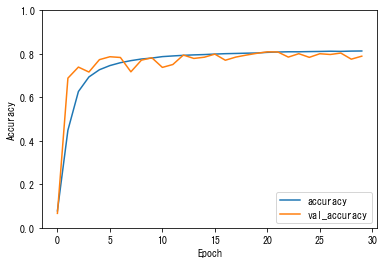

In [14]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [15]:
model.save(os.path.join(model_dir, "tf", "trained_model"))

INFO:tensorflow:Assets written to: D:\MachineLearning\models\tf\trained_model\assets


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 64, 64, 1)         0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 64, 64, 1)         0         
_________________________________________________________________
random_translation_1 (Random (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)       

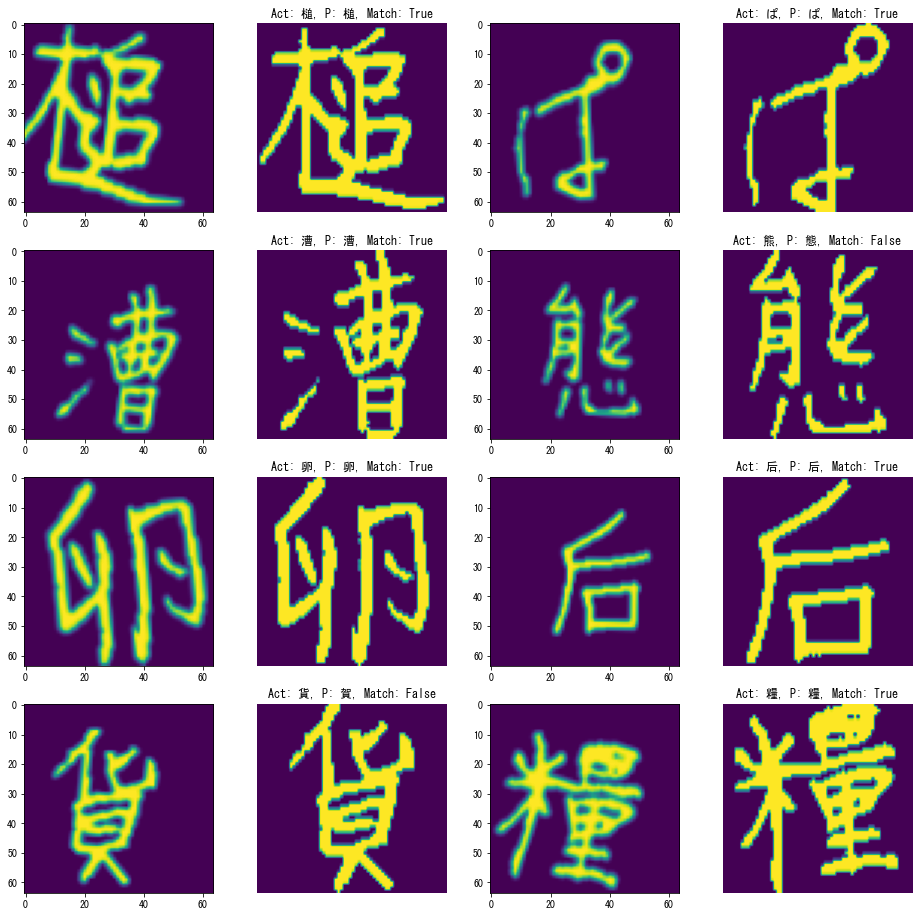

In [17]:
image_batch, label_batch = next(iter(val_ds))
p = model.predict(image_batch)
p = p.argmax(axis=1)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05,0.05), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.0, 0.5), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1), fill_mode='constant', fill_value=0)
])
aug = data_augmentation(image_batch)

plt.figure(figsize=(16, 16))
for i in range(8):
    ax = plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(aug[i].numpy().astype("uint8"))
   
    ax = plt.subplot(4, 4, 2 * i + 2)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'Act: {class_names[label]}, P: {class_names[p[i]]}, Match: {class_names[label] == class_names[p[i]]}')
    plt.axis("off")